In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm, M

In [3]:
def _4dvar_costfunction(x, xb, xtrac, yo, Pb, R, H_func=None):
    """
    x, xb: (ndim, 1)
    x_trac: (ndim, window)
    Pb: (ndim, ndim)
    yo: (N, window)
    R: (window, N, N)
    model, H_func: (window,)
    """
    assim_window_len = yo.shape[1]
    
    if H_func is None:
        H_func = [lambda arr: arr for _ in range(assim_window_len)]
        
    part1 = (xb-x).T @ np.linalg.inv(Pb) @ (xb-x)
    part2 = np.zeros_like(part1)
    for j in range(assim_window_len):
        yj = yo[:,[j]]
        Rj = R[j,:,:]
        H_j = H_func[j]
        xtracj = xtrac[:,[j]]
        part2 += (yj-H_j(xtracj)).T @ np.linalg.inv(Rj) @ (yj-H_j(xtracj))
    return 0.5 * (part1 + part2)

def _gradient_4dvar_costfunction(x, xb, xtrac, yo, Pb, R, M, H_func=None, H=None):
    """
    x, xb: (ndim, 1)
    xtrac: (ndim, window)
    Pb: (ndim, ndim)
    yo: (N, window)
    R: (window, N, N)
    H_func: (window,)
    M: (window, ndim, ndim)
    H: (window, N, ndim)
    """
    No, assim_window_len = yo.shape
    
    if H_func is None:
        H_func = [lambda arr: arr for _ in range(assim_window_len)]
        H = np.concatenate([np.eye(No)[np.newaxis] for i in range(assim_window_len)])
        
    part1 = np.linalg.inv(Pb) @ (x-xb)
    part2 = np.zeros_like(part1)
    for j in range(assim_window_len):
        yj = yo[:,[j]]
        Mj = M[j,:,:]
        Hj = H[j,:,:]
        Rj = R[j,:,:]
        H_fj = H_func[j]
        xtracj = xtrac[:,[j]]
        part2 += Mj.T @ Hj.T @ np.linalg.inv(Rj) @ (yj - H_fj(xtracj))
    return part1 - part2

In [4]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

dt = 0.01

In [5]:
obs_var = 2

win_len = 8  # assimilation window length (unit: time step)
win_num = 100  # how many assimilation windows. win_len*win_num <= X_nature.shape[1]

X_obserr = np.zeros_like(X_nature)
for i in range(3):
    obs = np.random.normal(scale=np.sqrt(obs_var), size=win_len*win_num).reshape((-1, win_len))
    obs = np.hstack((obs, np.zeros_like(obs)))
    obs = obs.ravel()
    X_obserr[i,:] = obs

In [7]:
idx = np.all(X_obserr != 0, axis=0)
X_nature_tmp = X_nature.copy()
X_nature_tmp[:,idx] = 0
X_obs = X_nature - X_nature_tmp + X_obserr
X_obs.shape

(3, 1600)

In [8]:
isobs = (X_obs[0,:] != 0) + 0  ################ np.any?
win_start = []
win_end = []
for idx, iso in enumerate(isobs):
    if idx == 0 and isobs[idx] == 1:
        # start window
        win_start.append(idx)
        continue
    if idx == len(isobs)-1:
        if isobs[idx] == 1:
            # end window
            win_end.append(idx)
            continue
        else:
            continue
    
    d = isobs[idx+1] - isobs[idx-1]
    if d == 1 and isobs[idx] == 1:
        # start window
        win_start.append(idx)
    elif d == -1 and isobs[idx] == 1:
        # end window
        win_end.append(idx)
        
win_range = list(zip(win_start, win_end))
win_range[:10]

[(0, 7),
 (16, 23),
 (32, 39),
 (48, 55),
 (64, 71),
 (80, 87),
 (96, 103),
 (112, 119),
 (128, 135),
 (144, 151)]

In [9]:
X_analysis = np.zeros_like(X_nature)
X_background = np.zeros_like(X_nature)

In [14]:
X_ini = np.array([[4, 5, 10]]).T
xb = X_ini.copy()

for iwin, (start_win, end_win) in enumerate(win_range):
    print('Assimilation:', iwin+1)
    
    ### assimilation stage
    win_len = end_win - start_win + 1
    ts = np.arange(0, (win_len-1)*dt, dt)
    x = xb.copy()
    
    # define R
    R = np.concatenate([obs_var*np.eye(3)[np.newaxis,:,:] for i in range(win_len)])

    # find observations in the assimilation window
    obs = X_obs[:,start_win:end_win+1]
    
    # gradient descent to minimize cost function
    for _ in range(1000):
        # calculate trajectory
        x_forecast = lorenz63_fdm(x.ravel(), ts)

        # calculate tangent linear model of every point on the trajectory
        Ms = []
        m = np.eye(3)
        for i in range(win_len):
            m = M(x_forecast[:,i], dt) @ m
            Ms.append(m)
        Ms = np.stack(Ms)

        # find gradient and gradient descent
        r = 0.01    # learning rate
        gradient = _gradient_4dvar_costfunction(x, xb, x_forecast, obs, Pb, R, Ms)
        x_new = x - r * gradient

        # stop criteria
        if np.linalg.norm(gradient) <= 0.001:
            x = x_new   # x is minize result
            break
        else:
            x = x_new
        
    # analysis trajectory and analysis point (at the end of window)
    xa_trajectory = lorenz63_fdm(x.ravel(), ts)
    xa = xa_trajectory[:,[-1]]
    X_analysis[:, start_win:end_win+1] = xa_trajectory
    
    ### forecast stage
    if iwin != len(win_range)-1:
        forecast_start = end_win + 1
        forecast_end = win_range[iwin+1][0] - 1
        forecast_len = forecast_end - forecast_start + 1
        ts = np.arange(0, (forecast_len-1)*dt, dt)
        xa_forecast = lorenz63_fdm(xa.ravel(), ts)
        xb = xa_forecast[:,[-1]]   # the background of next assimilation
        X_analysis[:, forecast_start:forecast_end+1] = xa_forecast
    else:
        # if it is the last assimilation window
        forecast_start = end_win + 1
        forecast_end = X_obs.shape[1]
        forecast_len = forecast_end - forecast_start + 1
        ts = np.arange(0, (forecast_len-1)*dt, dt)
        xa_forecast = lorenz63_fdm(xa.ravel(), ts)
        X_analysis[:, forecast_start:forecast_end+1] = xa_forecast

Assimilation: 1
Assimilation: 2
Assimilation: 3
Assimilation: 4
Assimilation: 5
Assimilation: 6
Assimilation: 7
Assimilation: 8
Assimilation: 9
Assimilation: 10
Assimilation: 11
Assimilation: 12
Assimilation: 13
Assimilation: 14
Assimilation: 15
Assimilation: 16
Assimilation: 17
Assimilation: 18
Assimilation: 19
Assimilation: 20
Assimilation: 21
Assimilation: 22
Assimilation: 23
Assimilation: 24
Assimilation: 25
Assimilation: 26
Assimilation: 27
Assimilation: 28
Assimilation: 29
Assimilation: 30
Assimilation: 31
Assimilation: 32
Assimilation: 33
Assimilation: 34
Assimilation: 35
Assimilation: 36
Assimilation: 37
Assimilation: 38
Assimilation: 39
Assimilation: 40
Assimilation: 41
Assimilation: 42
Assimilation: 43
Assimilation: 44
Assimilation: 45
Assimilation: 46
Assimilation: 47
Assimilation: 48
Assimilation: 49
Assimilation: 50
Assimilation: 51
Assimilation: 52
Assimilation: 53
Assimilation: 54
Assimilation: 55
Assimilation: 56
Assimilation: 57
Assimilation: 58
Assimilation: 59
Assimi

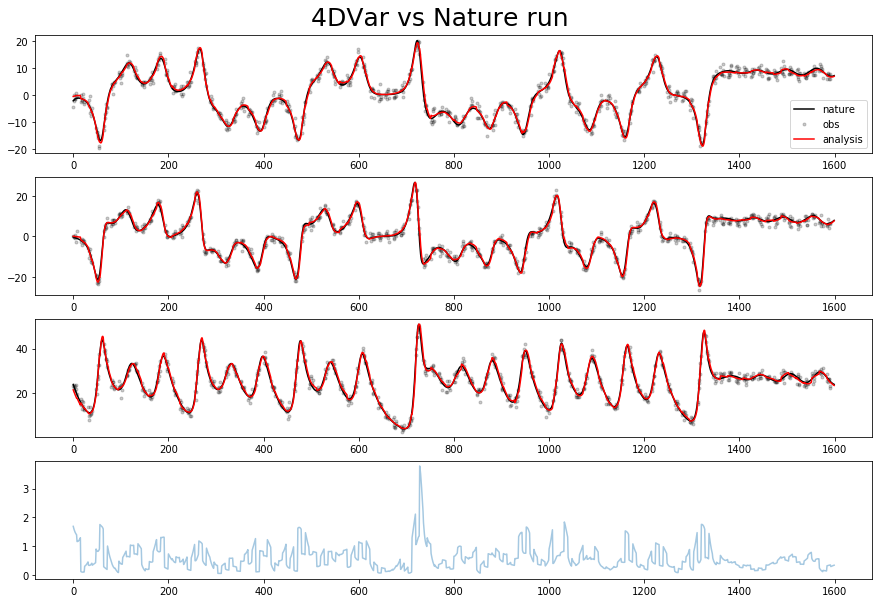

In [15]:
rmse_4dvar = np.sqrt(np.mean((X_analysis-X_nature)**2, axis=0))

# X_obs_tmp only for plot
X_obs_tmp = X_obs.copy()
X_obs_tmp[X_obs_tmp == 0] = np.nan

fig, axs = plt.subplots(nrows=4, figsize=(15, 10))
for i in range(3):
    axs[i].plot(X_nature[i,:], 'k', label='nature')
    axs[i].plot(X_obs_tmp[i,:], 'k.', alpha=0.2, label='obs')
    axs[i].plot(X_analysis[i,:], 'r', label='analysis')

axs[0].legend()
axs[3].plot(rmse_4dvar, alpha=0.4)
fig.suptitle('4DVar vs Nature run', y=0.92, fontsize=25);